In [124]:
#Importando Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Bibliotecas de visualização
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Bibliotecas p/ sistema de recomendação
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [125]:
#Importando Datasets
tags = pd.read_csv("data/ml-latest-small/tags.csv")
movies = pd.read_csv("data/ml-latest-small/movies.csv")
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
links = pd.read_csv("data/ml-latest-small/links.csv")

##### Descrição da variáveis

ratings.csv:
 - userid (ID do usuário)
 - movieid (ID do filme)
 - rating (avaliação do filme, em escala de 5 estrelas)
 - timestamp (Coordinated Universal Time (UTC))

tags.csv:
 - userid (ID do usuário)
 - movieid (ID do filme avaliado)
 - tag ("tag" atribuída pelo usuário ao filme)
 - timestamp (Coordinated Universal Time (UTC))

movies.csv:
 - movieid (ID do filme)
 - title (Título do filme)
 - genres (Gêneros atribuídos ao filme)

links.csv:
 - movieid (ID do filme usado em https://movielens.org)
 - imdbid (ID do filme usado em http://www.imdb.com)
 - tmdbid (ID do filme usado em https://www.themoviedb.org)

#### Análise dos dados

Tag Dataframe:

In [126]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [127]:
print ('Dimensões do dataframe tag: ')
print(f'Linhas:  {tags.shape[0]}')
print(f'Colunas: {tags.shape[1]}')

Dimensões do dataframe tag: 
Linhas:  3683
Colunas: 4


In [128]:
tags.dtypes ##tipo de dado em cada coluna.

userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object

In [129]:
tags.columns.values ##retorna todas as colunas do dado.

array(['userId', 'movieId', 'tag', 'timestamp'], dtype=object)

In [130]:
tags.dtypes.value_counts() ##tipos de valores.


int64     3
object    1
dtype: int64

In [131]:
tags.isna().any() ##dados nao numericos.

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [132]:
tags.isna().sum() ##detectar numeros faltantes em cada coluna

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Movies Dataframe:

In [133]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [134]:
print ('Dimensões do dataframe movies: ')
print(f'Linhas:  {movies.shape[0]}')
print(f'Colunas: {movies.shape[1]}')

Dimensões do dataframe movies: 
Linhas:  9742
Colunas: 3


In [135]:
movies.dtypes ##tipo de dado em cada coluna.

movieId     int64
title      object
genres     object
dtype: object

In [136]:
movies.columns.values ##retorna todas as colunas do dado.

array(['movieId', 'title', 'genres'], dtype=object)

In [137]:
movies.dtypes.value_counts() ##tipos de valores.

object    2
int64     1
dtype: int64

In [138]:
movies.isna().any() ##dados nao numericos.

movieId    False
title      False
genres     False
dtype: bool

In [139]:
movies.isna().sum() ##detectar numeros faltantes em cada coluna

movieId    0
title      0
genres     0
dtype: int64

Rating Dataframe:

In [140]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [141]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [142]:
print ('Dimensões do dataframe rating: ')
print(f'Linhas:  {ratings.shape[0]}')
print(f'Colunas: {ratings.shape[1]}')

Dimensões do dataframe rating: 
Linhas:  100836
Colunas: 4


In [143]:
ratings["rating"].unique() ##valores unicos da coluna rating

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [144]:
ratings.dtypes ##tipo de dado em cada coluna.

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [145]:
ratings.columns.values ##retorna todas as colunas do dado.

array(['userId', 'movieId', 'rating', 'timestamp'], dtype=object)

In [146]:
ratings.dtypes.value_counts() ##tipos de valores.


int64      3
float64    1
dtype: int64

In [147]:
ratings.isna().any() ##dados nao numericos.

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [148]:
ratings.isna().sum() ##detectar numeros faltantes em cada coluna

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

### Tratamento dos dados

Convetendo data

In [149]:
def convert_date(df, coluna):

    # Convertendo date e criando coluna do ano de avaliação
    df[coluna] = pd.to_datetime(df[coluna], unit='s')
    df[coluna] = pd.to_datetime(df[coluna], format='%Y-%m-%d')
    df['Ano de Avaliação'] = df.timestamp.dt.year
    return df;


Criando a coluna ano a partir do titulo

In [150]:
def convert_title_to_year(df):

    # Retirando todos os espaços da coluna "title" e criando a coluna 'year'(int)
    df['title']= df['title'].str.rstrip()
    df['year'] = df.title.str.slice(-5,-1,1)
    df['year'] = pd.to_numeric(df['year'], errors='coerce')

    return df;

Criando a média de avaliações

In [151]:
def calc_media_contagem_rating(df):
    # Agrupa as notas por movieId e calcula a respectiva média de avaliação, contagem de avaliações e contagem de usuarios que fizeram avaliações.
    temp = ratings.groupby(['movieId']).apply(lambda x: pd.Series(dict(media_ratings         =  (round(x.rating.mean(),1))
                                                                                ,ratings_count  =  ((x.rating.count()))
                                                                                ,user_count_rating  =  ((x.userId.nunique()))
                                                                                ))).reset_index()

    df = pd.merge(df, temp, how = 'left', on = ['movieId'])     

    return df;

Calculando contagem de tags e de usuarios que avaliaram

In [152]:
def calc_contagem_tags(df):
    temp = tags.groupby(['movieId']).apply(lambda x: pd.Series(dict(tags_count  =  ((x.tag.count()))
                                                                    ,user_count_tag  =  ((x.userId.nunique()))
                                                                    ))).reset_index()

    df = pd.merge(df, temp, how = 'left', on = ['movieId'])                   
    return df;   

Criando colunas de genero separadas

In [153]:
def colunas_genero(df):

    # Cria coluna com a quantidade de generos respectivo a cada filme
    df['qtde_generos'] = df.apply(lambda x : len(x['genres'].split("|")),axis=1)

    lista = ['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir'
                ,'Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','(no genres listed)']

    def atribui_um(coluna, genre):
        if coluna in genre:
            return 1
        else:
            return 0 
            
    for column in lista:

        # Divide a coluna "genres" pelo sinal "|" e atribui o valor um caso o genero esteja dentro dos valores para cada filme
        df[column] = df.apply(lambda x: atribui_um(column,x['genres'].split(sep="|",maxsplit=10)),axis=1)
    
    return df;

In [154]:
def colunas_diferenca_anos(df):
    # Busca a informação de ano de lançamento do filme na tabela movies (aproveitando para já trazer o título do filme)
    df = pd.merge(df, movies[['movieId', 'year', 'title']], how = 'left', on=['movieId'])

    # Cria uma coluna ilustrativa a distância em anos do lançamento do filme até o ano da avaliação
    df['Distancia em Anos'] = df['Ano de Avaliação'] - df['year'] 

    # Retira valores discrepantes em ratings
    df = df[df['Distancia em Anos'] > -1]

    return df;

In [155]:
# Convertendo o tipo de data nos Dataframes
ratings = convert_date (ratings, 'timestamp')
tags = convert_date (tags, 'timestamp')

# Adicionando as colunas
movies = convert_title_to_year(movies)
movies = calc_media_contagem_rating(movies)
movies = calc_contagem_tags(movies)
movies = colunas_genero(movies)
ratings = colunas_diferenca_anos(ratings)
tags = colunas_diferenca_anos(tags)


### Análise exploratória dos dados

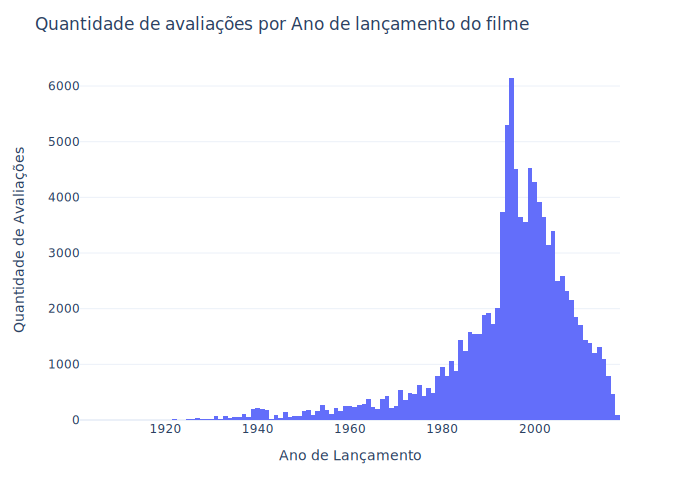

In [156]:
fig = px.histogram(ratings,x="year")

# Adiciona legenda e titulo dos eixos
fig.update_layout(
    title='Quantidade de avaliações por Ano de lançamento do filme',
    xaxis_title="Ano de Lançamento",
    yaxis_title="Quantidade de Avaliações",
    template='plotly_white')

# Mostra o gráfico
fig.show("svg")

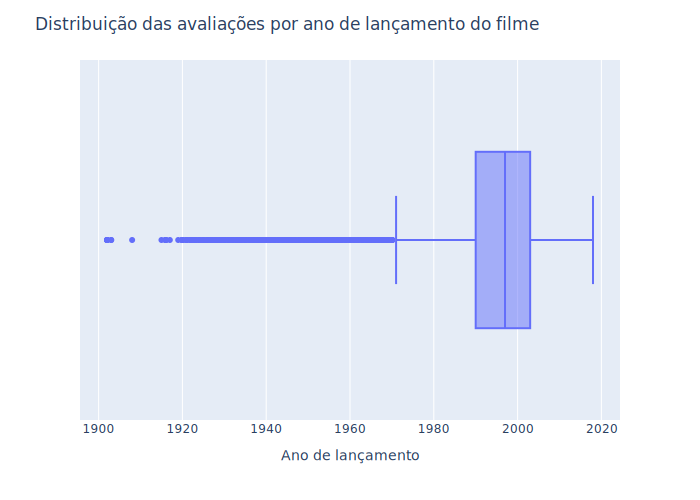

In [157]:
# Plota o boxplot das avaliações por ano de lançamento do filme
fig = px.box(ratings, x="year")

fig.update_layout(
    title ='Distribuição das avaliações por ano de lançamento do filme',
    xaxis_title="Ano de lançamento")
fig.show("svg")

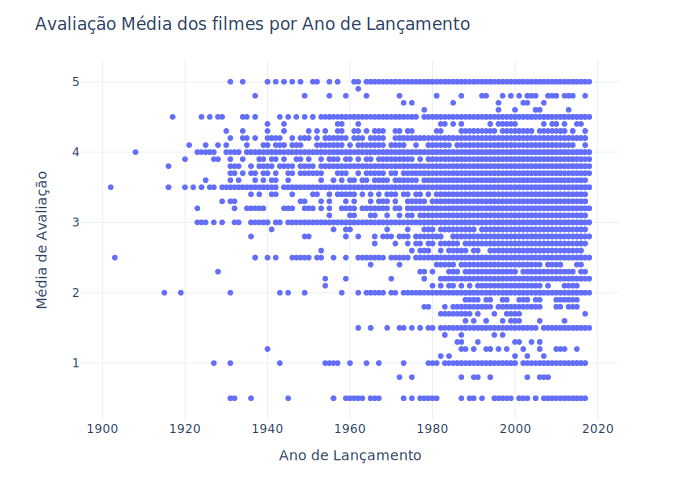

In [189]:
# Grafico de dispersão de Ano de lançamento por média de rating
fig = px.scatter(movies, x="year", y="media_ratings",hover_data=['media_ratings'])

fig.update_layout(
    title='Avaliação Média dos filmes por Ano de Lançamento',
    xaxis_title="Ano de Lançamento",
    yaxis_title="Média de Avaliação",
        template='plotly_white')

fig.show("svg")

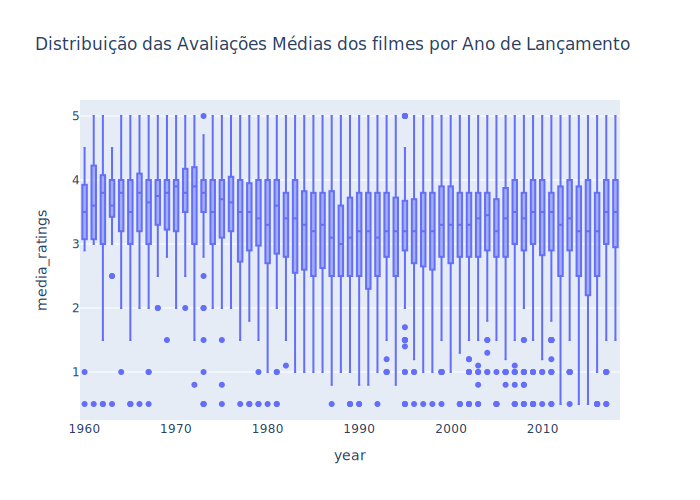

In [159]:
temp = movies.loc[(movies['year'] > 1959)]
# Plota a distribuição das avaliações médias dos filmes, por ano, para os filmes lançados a partir de 1960
fig = px.box(temp, x="year", y="media_ratings", title ='Distribuição das Avaliações Médias dos filmes por Ano de Lançamento' )
fig.show("svg")

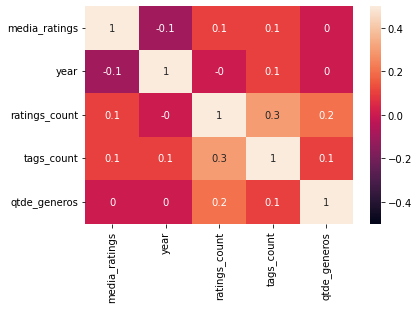

In [160]:
# Matriz de correlação
corr = round(movies[['media_ratings', 'year', 'ratings_count', 'tags_count', 'qtde_generos']].corr(),1)

sns.heatmap(corr, vmin=-0.5, vmax=0.5, annot=True);

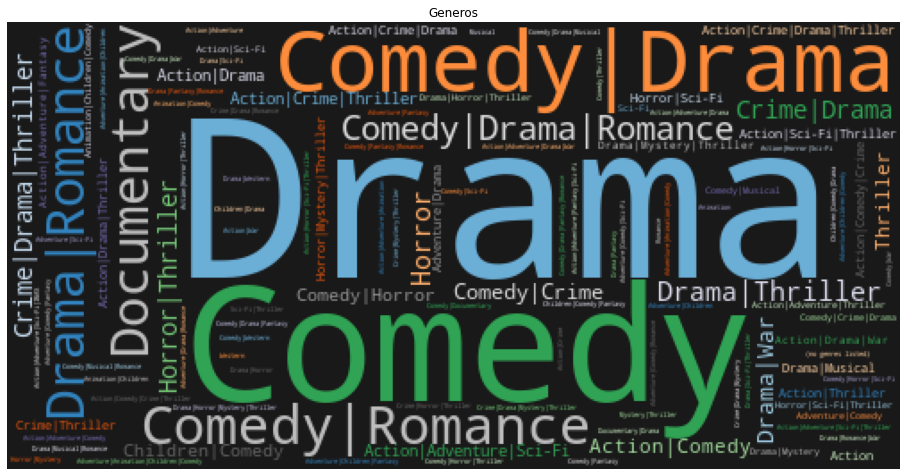

In [161]:
plt.figure(figsize=(16,10))
data = movies['genres'].value_counts().to_dict()
wc = WordCloud(width= 500, height = 250, random_state=1,background_color='#191919', colormap='tab20c').generate_from_frequencies(data)
plt.imshow(wc)
plt.title('Generos')
plt.axis('off')
plt.show()

In [181]:
ratings = pd.merge(ratings, movies[['movieId','Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir'
                    ,'Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','(no genres listed)','qtde_generos']], how = 'left', on=['movieId'])

# lista com todos os gêneros de filmes
lista_generos = ['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir'
                    ,'Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','(no genres listed)']

media, qntd_avaliacoes = [],[]

for coluna in lista_generos:

    # Cria um filtro para genero do filme
    temp = movies[movies[coluna] == 1].copy()
    temp_2 = ratings[ratings[coluna] == 1].copy()

    # Atribui a variavel qntd_avaliacoes  a quantidade de avaliações para filmes classificados pelo genero iterado
    qntd_avaliacoes.append(temp['ratings_count'].sum()) 

    # Atribui a variavel media_ratings com a média de ratings para filmes classificados pelo genero iterado
    media.append(round(temp_2['rating'].mean(), 2)) 

df_temp = pd.DataFrame({'Generos':lista_generos,
                        'Quantidade de Avaliações': qntd_avaliacoes,
                        'Media de Ratings':media })



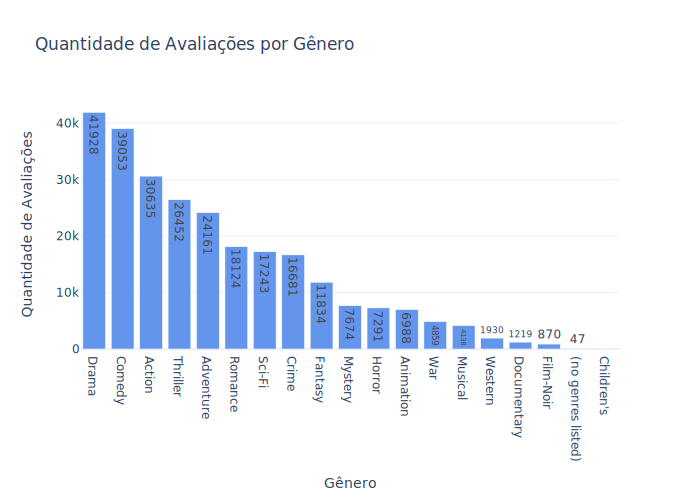

In [183]:
df_temp = df_temp.sort_values(by='Quantidade de Avaliações',ascending=False)

#Plota a quantidade de avaliações por gênero
fig = go.Figure(data=[go.Bar(
            x=df_temp.Generos, y=df_temp['Quantidade de Avaliações'],
            text=df_temp['Quantidade de Avaliações'],
            textposition='auto',
            marker_color='cornflowerblue',
        )])
fig.update_layout(
    title='Quantidade de Avaliações por Gênero',
    xaxis_title="Gênero",
    yaxis_title="Quantidade de Avaliações",
        template='plotly_white')

fig.show("svg")


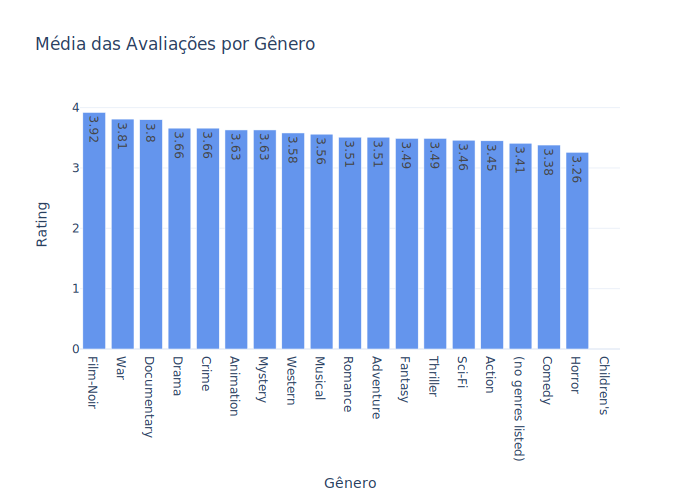

In [184]:
df_temp = df_temp.sort_values(by='Media de Ratings',ascending=False)

#Plota a avaliação média por gênero
fig = go.Figure(data=[go.Bar(
            x=df_temp.Generos, y=df_temp['Media de Ratings'],
            text=df_temp['Media de Ratings'],
            textposition='auto',
            marker_color='cornflowerblue',
                    )])
fig.update_layout(
    title='Média das Avaliações por Gênero',
    xaxis_title="Gênero",
    yaxis_title="Rating",
        template='plotly_white')

fig.show("svg")

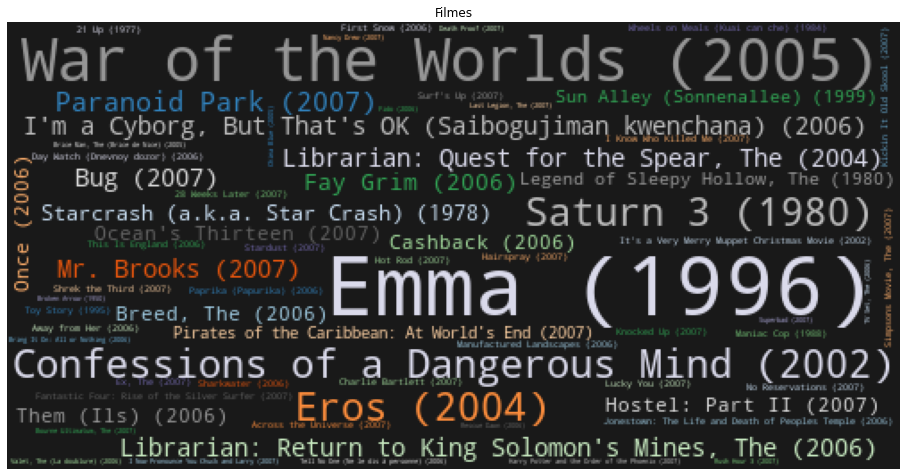

In [165]:
plt.figure(figsize=(16,10))
data = movies['title'].value_counts().to_dict()
wc = WordCloud(width= 500, height = 250, random_state=1,background_color='#191919', colormap='tab20c').generate_from_frequencies(data)
plt.imshow(wc)
plt.title('Filmes')
plt.axis('off')
plt.show()

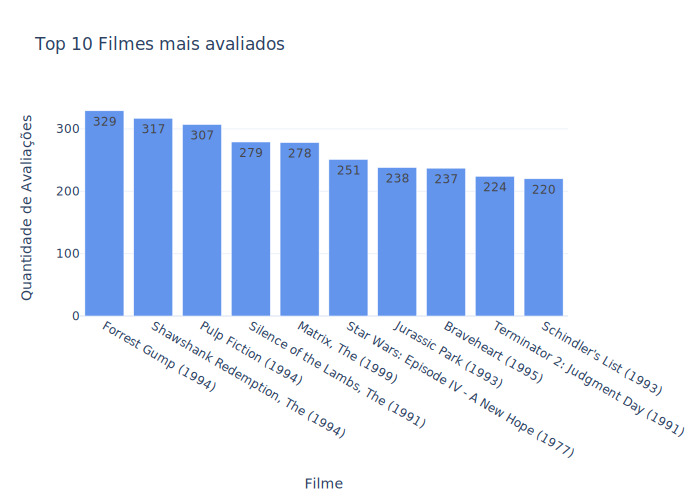

In [185]:
df_temp = movies.sort_values(by='ratings_count',ascending=False)

df_temp = df_temp [0:10]

# Plota o gráfico de número de avaliações dos 10 filmes com a maior quantidade de avaliações
fig = go.Figure(data=[go.Bar(
            x=df_temp.title, y=df_temp['ratings_count'],
            text=df_temp['ratings_count'],
            textposition='auto',
            marker_color='cornflowerblue',
        )])
fig.update_layout(
    title='Top 10 Filmes mais avaliados',
    xaxis_title="Filme",
    yaxis_title="Quantidade de Avaliações",
        template='plotly_white')

fig.show("svg")

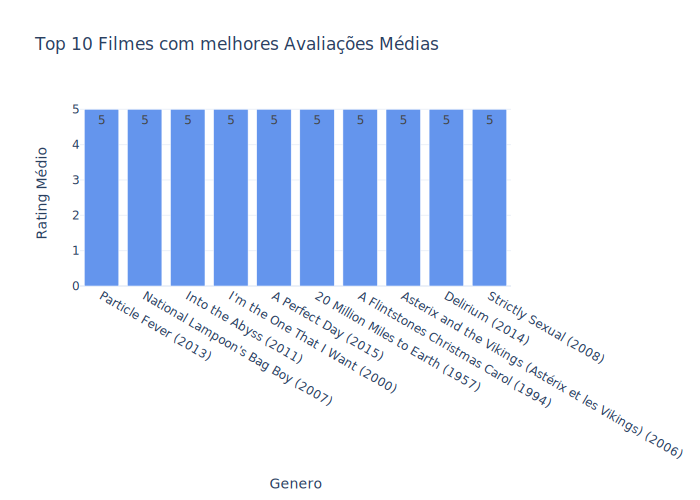

In [186]:
df_temp = movies.sort_values(by='media_ratings',ascending=False)

df_temp = df_temp [0:10]

# Plota o gráfico dos 10 filmes de melhor rating médio
fig = go.Figure(data=[go.Bar(
            x=df_temp.title, y=df_temp['media_ratings'],
            text=df_temp['media_ratings'],
            textposition='auto',
            marker_color='cornflowerblue',
        )])
fig.update_layout(
    title='Top 10 Filmes com melhores Avaliações Médias',
    xaxis_title="Genero",
    yaxis_title="Rating Médio",
        template='plotly_white')

fig.show("svg")

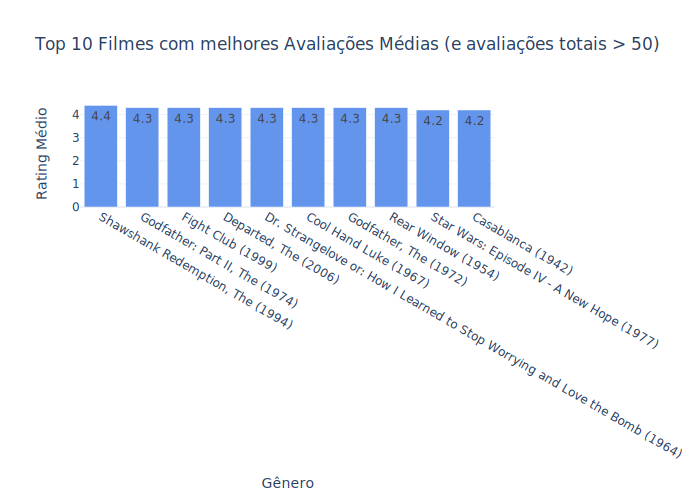

In [187]:
df_temp = movies[movies['ratings_count'] > 50].sort_values(by='media_ratings',ascending=False)

df_temp = df_temp [0:10]

#Plota o gráfico do top 10 filmes com melhor rating médio, e mais de 50 avaliações
fig = go.Figure(data=[go.Bar(
            x=df_temp.title, y=df_temp['media_ratings'],
            text=df_temp['media_ratings'],
            textposition='auto',
            marker_color='cornflowerblue',
        )])
fig.update_layout(
    title='Top 10 Filmes com melhores Avaliações Médias (e avaliações totais > 50)',
    xaxis_title="Gênero",
    yaxis_title="Rating Médio",
        template='plotly_white')

fig.show("svg")


### Sistema de recomendação

#### Sistema de recomendação usando o algoritmo KNN

In [169]:
#criando um novo dataframe onde cada coluna representa cada userId exclusivo e cada linha representa cada movieId exclusivo.
rec_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
rec_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
#Transformando NaN em 0 para melhor compreensão do algoritmo
rec_dataset.fillna(0,inplace=True)
rec_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

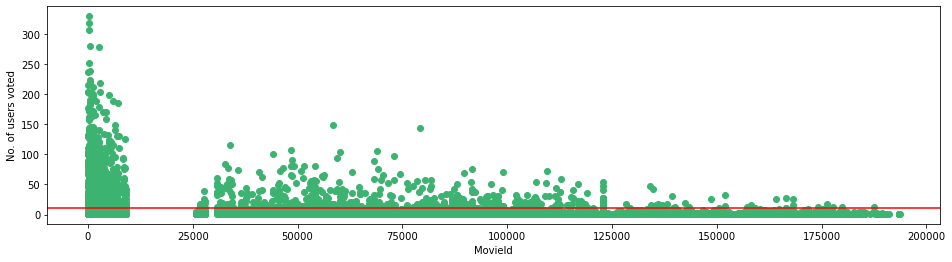

In [172]:
#visualizando o número de usuários que votaram com nosso limite de 10.
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [173]:
#Fazendo as modificações necessárias de acordo com o limite definido.
rec_dataset=rec_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
rec_dataset.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [174]:
#Aplicando o método csr_matrix ao conjunto de dados
csr_data = csr_matrix(rec_dataset.values)
rec_dataset.reset_index(inplace=True)

#### Modelo do sistema de recomendação de filmes

usando o algoritmo KNN para calcular a similaridade com a métrica

In [175]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [176]:
#Criando a função de recomendação
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = rec_dataset[rec_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = rec_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "Filme não encontrado. Verifique seu input"

#### Testando o sistema

In [177]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Up (2009),0.368857
2,Guardians of the Galaxy (2014),0.368758
3,Watchmen (2009),0.368558
4,Star Trek (2009),0.366029
5,Batman Begins (2005),0.362759
6,Avatar (2009),0.310893
7,Iron Man 2 (2010),0.307492
8,WALL·E (2008),0.298138
9,"Dark Knight, The (2008)",0.285835
10,"Avengers, The (2012)",0.285319


## Conclusão

Através de uma análise simples na base de dados do Movielens de Setembro de 2018, conseguimos fazer o tratamento, plotar alguns gráficos e tirar duvidas relacionadas as avaliações dos usuarios, além de criarmos um sistema simples de recomendação.

Para essa análise, foi utilizado o dataset MovieLens Latest Small, que é próprio para visualização de dados e aprendizado, portanto, relativamente menor. Para uma análise mais completa e com mais variáveis, a opção de MovieLens 20M que é uma opção mais completa.